In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sciopt
import qutip as qtp

## Hamiltonian parameters from ibmq_lima Q0 & Q1

In [2]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibmq_lima')

twopi = 2. * np.pi
true_params = backend.configuration().hamiltonian['vars']

# In Mrad/s
omega0 = true_params['wq0'] * 1.e-9
omega1 = true_params['wq1'] * 1.e-9
J = true_params['jq0q1'] * 1.e-9
Omega0 = true_params['omegad0'] * 1.e-9
U0 = 0.06 # from the CX pulse schedule

## Notes from `backend.configuration().hamiltonian['description']`

$$
\begin{align} \mathcal{H}/\hbar = & \sum_{i=0}^{4}\left(\frac{\omega_{q,i}}{2}(\mathbb{I}-\sigma_i^{z})+\frac{\Delta_{i}}{2}(O_i^2-O_i)+\Omega_{d,i}D_i(t)\sigma_i^{X}\right) \\ & + J_{0,1}(\sigma_{0}^{+}\sigma_{1}^{-}+\sigma_{0}^{-}\sigma_{1}^{+}) + J_{1,2}(\sigma_{1}^{+}\sigma_{2}^{-}+\sigma_{1}^{-}\sigma_{2}^{+}) + J_{1,3}(\sigma_{1}^{+}\sigma_{3}^{-}+\sigma_{1}^{-}\sigma_{3}^{+}) + J_{3,4}(\sigma_{3}^{+}\sigma_{4}^{-}+\sigma_{3}^{-}\sigma_{4}^{+}) \\ & + \Omega_{d,0}(U_{0}^{(0,1)}(t))\sigma_{0}^{X} + \Omega_{d,1}(U_{1}^{(1,0)}(t)+U_{3}^{(1,3)}(t)+U_{2}^{(1,2)}(t))\sigma_{1}^{X} \\ & + \Omega_{d,2}(U_{4}^{(2,1)}(t))\sigma_{2}^{X} + \Omega_{d,3}(U_{6}^{(3,4)}(t)+U_{5}^{(3,1)}(t))\sigma_{3}^{X} \\ & + \Omega_{d,4}(U_{7}^{(4,3)}(t))\sigma_{4}^{X} \\ \end{align}
$$

Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:

$(\mathbb{I}-\sigma_{i}^z)/2 \rightarrow O_i \equiv b^\dagger_{i} b_{i}$,

$\sigma_{+} \rightarrow b^\dagger$,

$\sigma_{-} \rightarrow b$,

$\sigma_{i}^X \rightarrow b^\dagger_{i} + b_{i}$.

Qubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing due to the qubit-qubit interactions.

Quantities are returned in angular frequencies, with units 2*pi*GHz.

WARNING: Currently not all system Hamiltonian information is available to the public, missing values have been replaced with 0.

## Modeling with QuTiP

In [3]:
# Free Hamiltonian
H0 = qtp.tensor(omega0 * qtp.charge(1, 0), qtp.qeye(2)) + qtp.tensor(qtp.qeye(2), omega1 * qtp.charge(1, 0))
# Interaction Hamiltonian
Hint = J * (qtp.tensor(qtp.create(2), qtp.destroy(2)) + qtp.tensor(qtp.destroy(2), qtp.create(2)))
# Drive Hamiltonian (sigma^X_0)
Hdrive = Omega0 * U0 * qtp.tensor(qtp.sigmax(), qtp.qeye(2))

## Demo: Lab-frame simulation of drive @ $\omega_1$

In [4]:
hamiltonian = [H0, Hint, (Hdrive, f'cos({omega1} * t)')]

# Time evolution for 1000 cycles, ~10 time points per cycle
tlist = np.linspace(0., twopi / omega1 * 1000, 10000)

e_ops = []
paulis = [qtp.qeye(2), qtp.sigmax(), qtp.sigmay(), qtp.sigmaz()]
for p0 in paulis:
    for p1 in paulis:
        e_ops.append(qtp.tensor(p0, p1))
        
psi0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # Initial state |00>
result_0 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

psi0 = qtp.tensor(qtp.basis(2, 1), qtp.basis(2, 0)) # Initial state |10>
result_1 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

obs_0 = {}
obs_1 = {}
for p0 in 'ixyz':
    for p1 in 'ixyz':
        exp_0 = result_0.expect[len(obs_0)]
        exp_1 = result_1.expect[len(obs_1)]
        obs_0[p0 + p1] = exp_0
        obs_1[p0 + p1] = exp_1

### $\langle IZ \rangle$

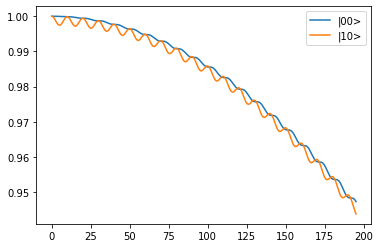

In [5]:
plt.plot(tlist, obs_0['iz'], label='|00>')
plt.plot(tlist, obs_1['iz'], label='|10>')
plt.legend()

### $\langle IX \rangle \sin(\omega_1 t) + \langle IY \rangle \cos(\omega_1 t)$

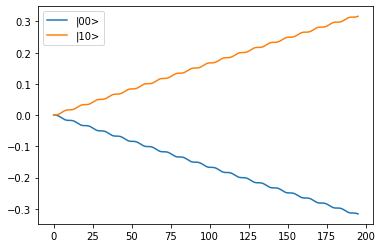

In [6]:
plt.plot(tlist, np.sin(omega1 * tlist) * obs_0['ix'] + np.cos(omega1 * tlist) * obs_0['iy'], label='|00>')
plt.plot(tlist, np.sin(omega1 * tlist) * obs_1['ix'] + np.cos(omega1 * tlist) * obs_1['iy'], label='|10>')
plt.legend()

### $\langle ZI \rangle$

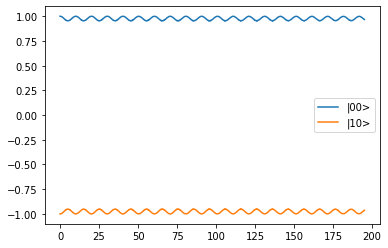

In [7]:
plt.plot(tlist, obs_0['zi'], label='|00>')
plt.plot(tlist, obs_1['zi'], label='|10>')
plt.legend() 

### $\langle XI \rangle \sin(\omega_0 t) + \langle YI \rangle \cos(\omega_0 t)$

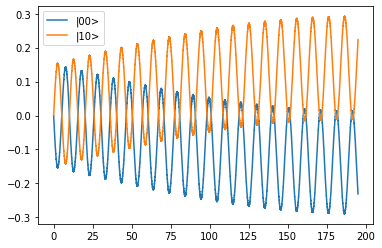

In [8]:
plt.plot(tlist, np.sin(omega0 * tlist) * obs_0['xi'] + np.cos(omega0 * tlist) * obs_0['yi'], label='|00>')
plt.plot(tlist, np.sin(omega0 * tlist) * obs_1['xi'] + np.cos(omega0 * tlist) * obs_1['yi'], label='|10>')
plt.legend()

### Observations

We see ZX, IX, and ZI actions, but the strengths of the two operators don't seem consistent with Magesan & Gambetta

$H_{\mathrm{CR}} = (\Delta - \sqrt{\Delta^2 + \Omega^2}) \frac{ZI}{2} - \left(\frac{J\Omega}{\sqrt{\Delta^2 + \Omega^2}} \right) \frac{ZX}{2},$

where $\Delta = \tilde{\omega}_0 - \tilde{\omega}_1$ (difference of dressed frequencies).

With the parameters above, $(\Delta - \sqrt{\Delta^2 + \Omega^2}) \times t_{\mathrm{last}}$ is

In [55]:
# Time evolution for 1000 cycles, ~10 time points per cycle
tlist = np.linspace(0., twopi / omega1 * 1000, 10000)
Delta = omega0 - omega1
#(Delta - np.sqrt(Delta ** 2 + (Omega0 * U0) ** 2)) * tlist[-1] / twopi
print(Delta)
print(np.sqrt(Delta ** 2 + (Omega0 * U0) ** 2))
print((Delta - np.sqrt(Delta ** 2 + (Omega0 * U0) ** 2)) / twopi * tlist[-1])

-0.6153023286560746
0.6225505571786181
-38.42090393708456


cycles, whereas we have ~19 cycles in the X-Y plane. Twice?

As for ZX, $J\Omega/\sqrt{\Delta^2 + \Omega^2} \times t_{\mathrm{last}}$ is

In [57]:
J * Omega0 * U0 / np.sqrt(Delta**2 + (Omega0 * U0)**2) * tlist[-1]

0.3290273239864266

radians (but we can't really tell the phase advance in the ZX plot).

The result also seems inconsistent with the actual pulse schedule; in ibmq_lima a CR GaussianSquare with duration 528 (116ns) and width 272 (60ns) is supposed to correspond to ZX(pi/4) -> tlast = 200ns should effect more than ZX(pi/2), i.e. the coefficient should be ~0.8 rather than 0.33. Although this could be due to a misinterpretation of the drive amplitude in the CX schedule (very likely).

Is there a frequency shift?

## Going a step back: single-qubit drive

In [9]:
hamiltonian = [H0, Hint, (Hdrive, f'cos({omega0} * t)')]
        
psi0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # Initial state |00>
result_0 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

psi0 = qtp.tensor(qtp.basis(2, 1), qtp.basis(2, 0)) # Initial state |10>
result_1 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

obs_0 = {}
obs_1 = {}
for p0 in 'ixyz':
    for p1 in 'ixyz':
        exp_0 = result_0.expect[len(obs_0)]
        exp_1 = result_1.expect[len(obs_1)]
        obs_0[p0 + p1] = exp_0
        obs_1[p0 + p1] = exp_1

### $\langle IZ \rangle$

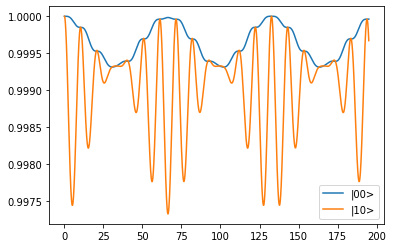

In [10]:
plt.plot(tlist, obs_0['iz'], label='|00>')
plt.plot(tlist, obs_1['iz'], label='|10>')
plt.legend()

### $\langle ZI \rangle$

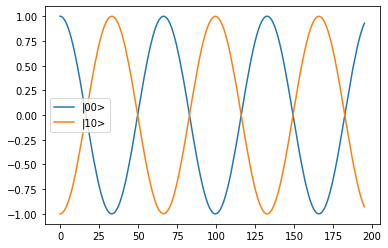

In [11]:
plt.plot(tlist, obs_0['zi'], label='|00>')
plt.plot(tlist, obs_1['zi'], label='|10>')
plt.legend() 

### $\langle IX \rangle \sin(\omega_1 t) + \langle IY \rangle \cos(\omega_1 t)$

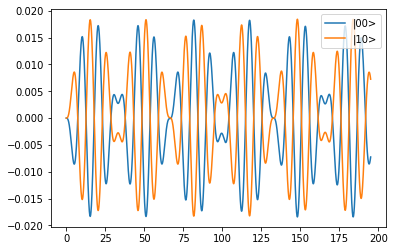

In [12]:
plt.plot(tlist, np.sin(omega1 * tlist) * obs_0['ix'] + np.cos(omega1 * tlist) * obs_0['iy'], label='|00>')
plt.plot(tlist, np.sin(omega1 * tlist) * obs_1['ix'] + np.cos(omega1 * tlist) * obs_1['iy'], label='|10>')
plt.legend()

### $\langle XI \rangle \sin(\omega_0 t) + \langle YI \rangle \cos(\omega_0 t)$

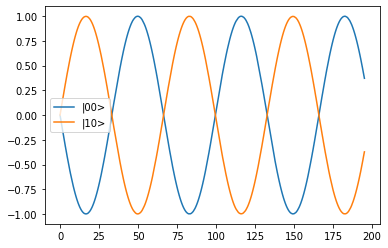

In [13]:
plt.plot(tlist, np.sin(omega0 * tlist) * obs_0['xi'] + np.cos(omega0 * tlist) * obs_0['yi'], label='|00>')
plt.plot(tlist, np.sin(omega0 * tlist) * obs_1['xi'] + np.cos(omega0 * tlist) * obs_1['yi'], label='|10>')
plt.legend()

In [14]:
popt, _ = sciopt.curve_fit(lambda t, omega: np.cos(omega * t), tlist, obs_0['zi'], p0=(Omega0 * U0))
popt / (Omega0 * U0)

array([0.99982024])

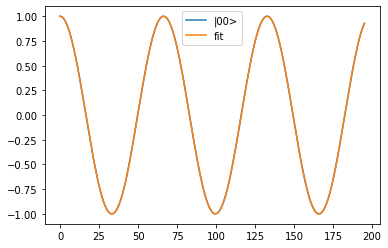

In [15]:
plt.plot(tlist, obs_0['zi'], label='|00>')
plt.plot(tlist, np.cos(popt[0] * tlist), label='fit')
plt.legend()

We see that $\langle ZI \rangle \propto \cos(\Omega_0 U_0 t)$ -> $|0\rangle$ comes back at $t = 2\pi/\Omega_0 U_0$ -> Time evolution is $\exp \Omega_0 U_0 / 2$ ($\exp (-i\alpha)$ comes back at $\alpha = \pi$).

This is consistent with 1904.06560

## What happens to IZ with no drive?

In [16]:
hamiltonian = [H0, Hint]
        
psi0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # Initial state |00>
result_0 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

psi0 = qtp.tensor(qtp.basis(2, 1), qtp.basis(2, 0)) # Initial state |10>
result_1 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

obs_0 = {}
obs_1 = {}
for p0 in 'ixyz':
    for p1 in 'ixyz':
        exp_0 = result_0.expect[len(obs_0)]
        exp_1 = result_1.expect[len(obs_1)]
        obs_0[p0 + p1] = exp_0
        obs_1[p0 + p1] = exp_1

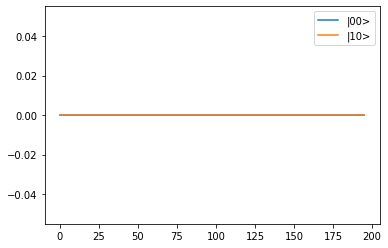

In [17]:
plt.plot(tlist, np.sin(omega1 * tlist) * obs_0['ix'] + np.cos(omega1 * tlist) * obs_0['iy'], label='|00>')
plt.plot(tlist, np.sin(omega1 * tlist) * obs_1['ix'] + np.cos(omega1 * tlist) * obs_1['iy'], label='|10>')
plt.legend()

## IZ frequency scan

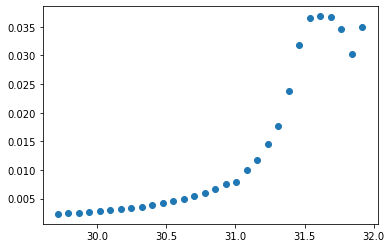

In [22]:
omega_vals = np.linspace(omega0 - twopi * 0.3, omega0 + twopi * 0.05, 30)
diffs = np.empty_like(omega_vals)
scan_results = []
for iom, omega in enumerate(omega_vals):
    hamiltonian = [H0, Hint, (Hdrive, f'cos({omega} * t)')]

    psi0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # Initial state |00>
    result_0 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

    obs_0 = {}
    for p0 in 'ixyz':
        for p1 in 'ixyz':
            exp_0 = result_0.expect[len(obs_0)]
            obs_0[p0 + p1] = exp_0

    xy = np.sin(omega1 * tlist) * obs_0['ix'] + np.cos(omega1 * tlist) * obs_0['iy']
    diffs[iom] = np.amax(xy) - np.amin(xy)
    scan_results.append(obs_0)

plt.scatter(omega_vals, diffs)

Increased detuning -> similar effect as $J \rightarrow 0$

In [32]:
(omega_vals[24] - omega0) / twopi

-0.010344827586207169

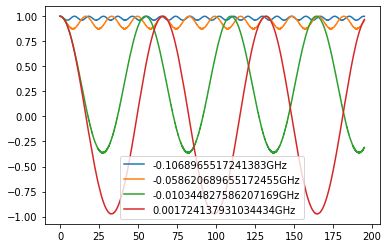

In [33]:
plt.plot(tlist, scan_results[16]['zi'], label=f'{(omega_vals[16] - omega0) / twopi}GHz')
plt.plot(tlist, scan_results[20]['zi'], label=f'{(omega_vals[20] - omega0) / twopi}GHz')
plt.plot(tlist, scan_results[24]['zi'], label=f'{(omega_vals[24] - omega0) / twopi}GHz')
plt.plot(tlist, scan_results[25]['zi'], label=f'{(omega_vals[25] - omega0) / twopi}GHz')

plt.legend()

## Back to CR. Frequency scan

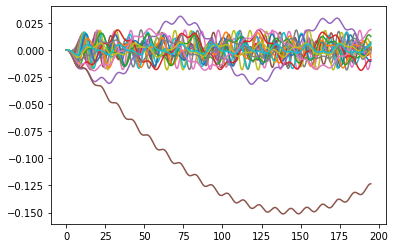

In [46]:
omega_vals = np.linspace(omega1 - twopi * 0.3, omega1 + twopi * 0.05, 30)

scan_results = []
for iom, omega in enumerate(omega_vals):
    hamiltonian = [H0, Hint, (Hdrive, f'cos({omega} * t)')]

    psi0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # Initial state |00>
    result_0 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

    obs_0 = {}
    for p0 in 'ixyz':
        for p1 in 'ixyz':
            exp_0 = result_0.expect[len(obs_0)]
            obs_0[p0 + p1] = exp_0

    scan_results.append(obs_0)
    plt.plot(tlist, np.sin(omega1 * tlist) * obs_0['ix'] + np.cos(omega1 * tlist) * obs_0['iy'], label='{:.3f}GHz'.format((omega - omega1) / twopi))
    
plt.legend()

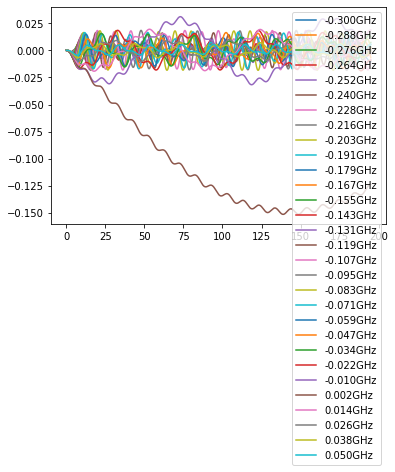

In [47]:
for omega, res in zip(omega_vals, scan_results):
    plt.plot(tlist, np.sin(omega1 * tlist) * res['ix'] + np.cos(omega1 * tlist) * res['iy'], label='{:.3f}GHz'.format((omega - omega1) / twopi))
    
plt.legend()

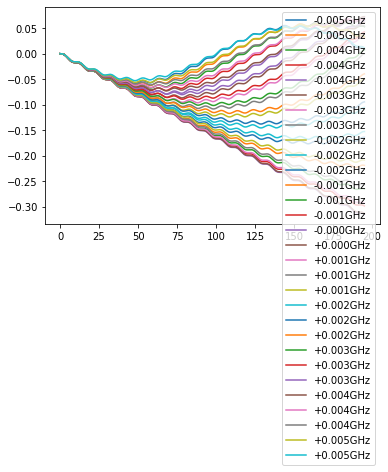

In [48]:
omega_vals = np.linspace(omega1 - twopi * 0.005, omega1 + twopi * 0.005, 30)

scan_results = []
for iom, omega in enumerate(omega_vals):
    hamiltonian = [H0, Hint, (Hdrive, f'cos({omega} * t)')]

    psi0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # Initial state |00>
    result_0 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

    obs_0 = {}
    for p0 in 'ixyz':
        for p1 in 'ixyz':
            exp_0 = result_0.expect[len(obs_0)]
            obs_0[p0 + p1] = exp_0

    scan_results.append(obs_0)
    plt.plot(tlist, np.sin(omega1 * tlist) * obs_0['ix'] + np.cos(omega1 * tlist) * obs_0['iy'], label='{:+.3f}GHz'.format((omega - omega1) / twopi))
    
plt.legend()

## Driving it longer

In [49]:
hamiltonian = [H0, Hint, (Hdrive, f'cos({omega1} * t)')]

# Time evolution for 1000 cycles, ~10 time points per cycle
tlist = np.linspace(0., twopi / omega1 * 5000, 50000)

e_ops = []
paulis = [qtp.qeye(2), qtp.sigmax(), qtp.sigmay(), qtp.sigmaz()]
for p0 in paulis:
    for p1 in paulis:
        e_ops.append(qtp.tensor(p0, p1))
        
psi0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # Initial state |00>
result_0 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

psi0 = qtp.tensor(qtp.basis(2, 1), qtp.basis(2, 0)) # Initial state |10>
result_1 = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

obs_0 = {}
obs_1 = {}
for p0 in 'ixyz':
    for p1 in 'ixyz':
        exp_0 = result_0.expect[len(obs_0)]
        exp_1 = result_1.expect[len(obs_1)]
        obs_0[p0 + p1] = exp_0
        obs_1[p0 + p1] = exp_1

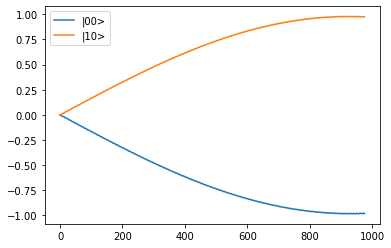

In [50]:
plt.plot(tlist, np.sin(omega1 * tlist) * obs_0['ix'] + np.cos(omega1 * tlist) * obs_0['iy'], label='|00>')
plt.plot(tlist, np.sin(omega1 * tlist) * obs_1['ix'] + np.cos(omega1 * tlist) * obs_1['iy'], label='|10>')
plt.legend()

In [51]:
p0 = J * Omega0 * U0 / np.sqrt((omega0 - omega1)**2 + (Omega0 * U0)**2)
popt, _ = sciopt.curve_fit(lambda t, omega: np.sin(omega * t), tlist, np.sin(omega1 * tlist) * obs_1['ix'] + np.cos(omega1 * tlist) * obs_1['iy'], p0=p0)
popt / p0

array([0.97440302])

OK maybe this is consistent with Magesan and Gambetta - still can't make sense of the ZI oscillation though..

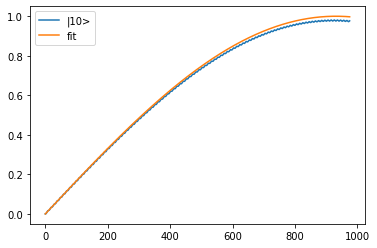

In [53]:
plt.plot(tlist, np.sin(omega1 * tlist) * obs_1['ix'] + np.cos(omega1 * tlist) * obs_1['iy'], label='|10>')
plt.plot(tlist, np.sin(p0 * tlist), label='fit')
plt.legend()